In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# I am familiarizing myself with the matplotlib.pylot library, 
# so it is the only plotting library I will be using in this project.

import random
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

# Import and Prep Data

In [2]:
feature_data = pd.read_csv('data/train_features.csv')
salary_data = pd.read_csv('data/train_salaries.csv')

In [3]:
feature_data.head() #take a look at the features
# There are 8 variables, 6 categorical, 2 numerical
# jobId will probably not be used in the model, 
# since it looks like it uniquely identifies each row of data

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
salary_data.head() # take a look at the target data
# numerical target indicates we should attempt to fit some type of regression model

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
# join the features data with the target variable(salary), 
# the join will be done on the jobId column
all_data = feature_data.merge(salary_data, how = 'inner', on='jobId',validate='1:1')
# we're doing an inner join, because we can only use data where both the target and feature variables are available

In [6]:
all_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
#split into two groups
TEST_PERCENT = 0.2

#create a list of integers that is a certain percent of the
#length of the dataset, which will be the rows that end up in 
#the test dataset
test_index = random.sample(range(len(all_data)),int(len(all_data)*TEST_PERCENT))
train_index = np.setdiff1d(np.arange(0,len(all_data)), test_index)
all_data_test = all_data.iloc[test_index]
all_data_train = all_data.iloc[train_index]

In [8]:
len(all_data_train)

800000

In [9]:
len(all_data_test)

200000

In [10]:
# assuming that all data is unique in the original dataset
# however, just because there are 1million unique jobIds does not mean this is the case

# Exploratory Data Analysis

In [11]:
#look at each column

#companyId
all_data_train['companyId'].nunique()

63

In [12]:
all_data_train['companyId'].value_counts().sort_values() #visual might be better here

COMP8     12482
COMP0     12502
COMP29    12510
COMP57    12518
COMP53    12530
          ...  
COMP35    12865
COMP59    12867
COMP3     12872
COMP30    12878
COMP39    13012
Name: companyId, Length: 63, dtype: int64

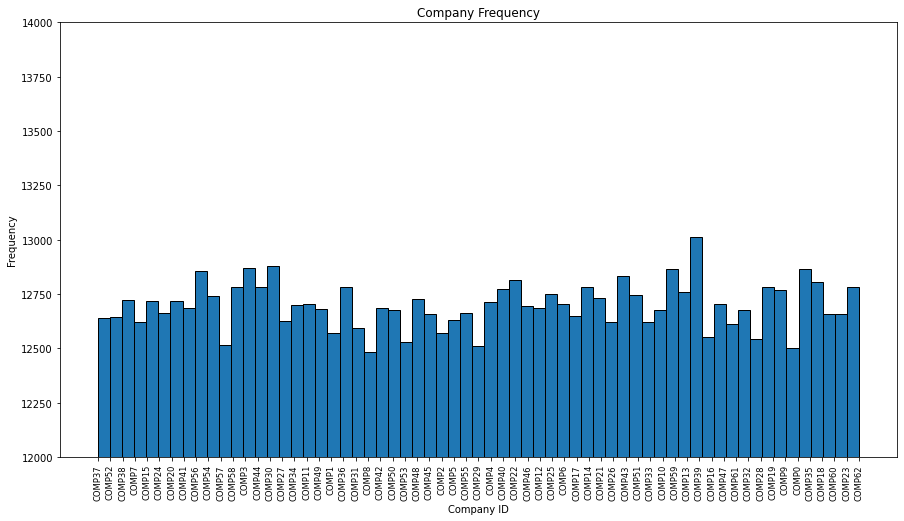

In [13]:
plt.figure(figsize = (15,8))
plt.hist(all_data_train['companyId'], bins = 63, edgecolor = 'black')
plt.title('Company Frequency')
plt.xlabel('Company ID')
plt.ylabel('Frequency')
plt.ylim(12000,14000)
plt.xticks(rotation=90,fontweight='medium',fontsize='small')
plt.show() # hist displays without this, but this gets rid of all of the extra data

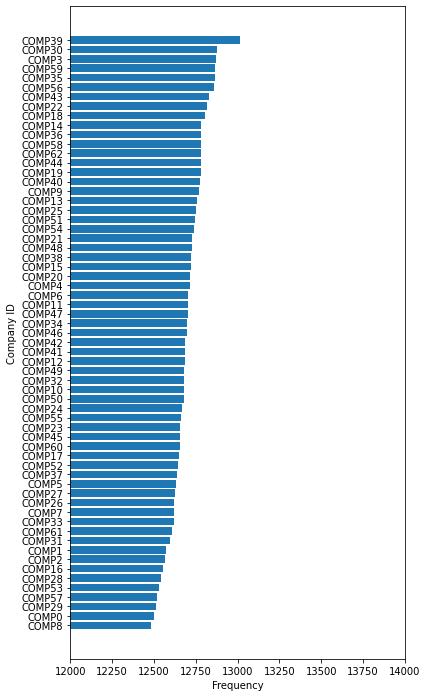

In [14]:
# another way to look at it
fig, ax = plt.subplots(figsize = (6,12))
ax.barh(all_data_train['companyId'].value_counts().sort_values().index,all_data_train['companyId'].value_counts().sort_values())
ax.set_xlim(12000,14000)
ax.set_ylabel('Company ID')
ax.set_xlabel('Frequency')
plt.show()

In [15]:
# looks like each company appears between 12750 and 13250 times out of 818K data points, a range of 500

In [16]:
#jobType
all_data_train['jobType'].nunique()

8

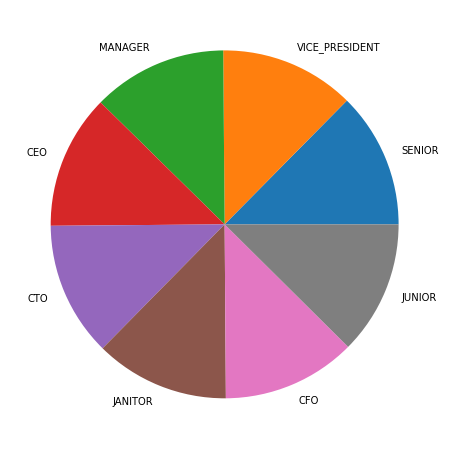

In [17]:
fig, ax = plt.subplots(figsize = (8,8))
plt.pie(all_data_train['jobType'].value_counts(), labels = all_data_train['jobType'].value_counts().index)
plt.show()

In [18]:
# looks a bit suspicious, let's check that it's accurate
all_data_train['jobType'].value_counts()/len(all_data_train)

SENIOR            0.125981
VICE_PRESIDENT    0.125333
MANAGER           0.125061
CEO               0.124954
CTO               0.124923
JANITOR           0.124880
CFO               0.124521
JUNIOR            0.124347
Name: jobType, dtype: float64

In [19]:
#about 12.5% of each jobType, what an odd dataset

In [20]:
# is there a correlation between jobType and salary
all_data_train.groupby(['jobType']).mean()['salary']

jobType
CEO               145.308224
CFO               135.533523
CTO               135.410795
JANITOR            70.769519
JUNIOR             95.401204
MANAGER           115.429370
SENIOR            105.385543
VICE_PRESIDENT    125.416343
Name: salary, dtype: float64

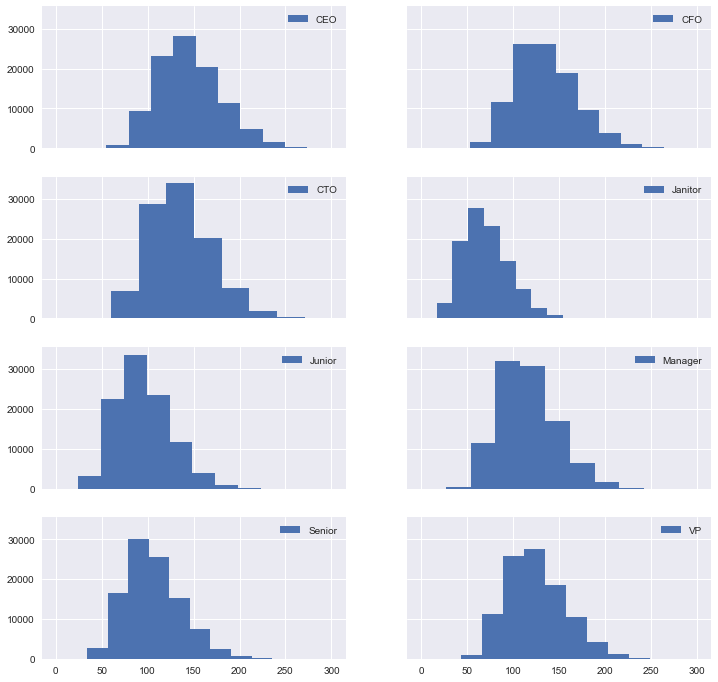

In [21]:
# plot salary by jobType
# use subplots here
plt.style.use('seaborn')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,2,figsize=(12,12),sharex=True,sharey=True)

ax1[0].hist(all_data_train[all_data_train['jobType'] == 'CEO']['salary'], label = 'CEO')
ax1[1].hist(all_data_train[all_data_train['jobType'] == 'CFO']['salary'], label = 'CFO')
ax2[0].hist(all_data_train[all_data_train['jobType'] == 'CTO']['salary'], label = 'CTO')
ax2[1].hist(all_data_train[all_data_train['jobType'] == 'JANITOR']['salary'], label = 'Janitor')
ax3[0].hist(all_data_train[all_data_train['jobType'] == 'JUNIOR']['salary'], label = 'Junior')
ax3[1].hist(all_data_train[all_data_train['jobType'] == 'MANAGER']['salary'], label = 'Manager')
ax4[0].hist(all_data_train[all_data_train['jobType'] == 'SENIOR']['salary'], label = 'Senior')
ax4[1].hist(all_data_train[all_data_train['jobType'] == 'VICE_PRESIDENT']['salary'], label = 'VP')
ax1[0].legend()
ax1[1].legend()
ax2[0].legend()
ax2[1].legend()
ax3[0].legend()
ax3[1].legend()
ax4[0].legend()
ax4[1].legend()
plt.show()

#next time, put this into a for loop

In [22]:
# C-level, Manager, and VP have a wider range with the highest maximums, and janitor's salary range is on the lower end.
# The bulk of the C-level job salaries are greater than the Senior and Manager, but the ranges aren't that different, which is surprising

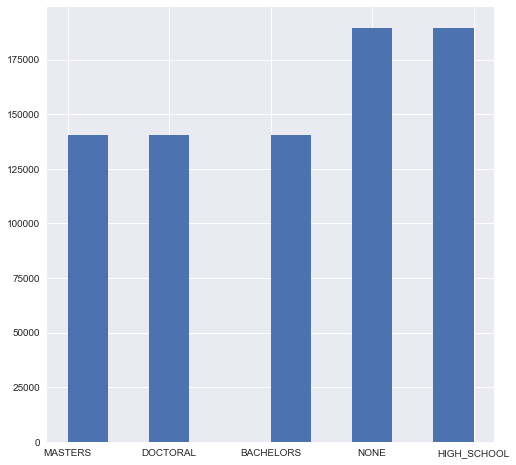

In [23]:
#degree
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(all_data_train['degree'])
plt.show()

In [24]:
# break the data up by degree and jobType

#labels = all_data_train['jobType'].sort_values().unique()
#fig, ax = plt.subplots()
# for every job type, count the number of each type of degree
#ax.bar(all_data_train['degree'].value_counts())

#skipping this for now, need to understand the various plot implementations better

In [25]:
# roughly, the data is evenly split between high school and lower, and bachelor's or higher

In [26]:
#major
all_data_train['major'].value_counts()

NONE           425895
CHEMISTRY       47167
ENGINEERING     46901
BUSINESS        46894
COMPSCI         46830
LITERATURE      46733
PHYSICS         46672
BIOLOGY         46668
MATH            46240
Name: major, dtype: int64

In [27]:
#any empty strings?
all_data_train['major'] == ''

0         False
2         False
3         False
4         False
6         False
          ...  
999995    False
999996    False
999997    False
999998    False
999999    False
Name: major, Length: 800000, dtype: bool

In [28]:
#about half of the data points have no major, and the other half are about equally split at around 47k

In [29]:
#majors by degree type
all_data_train[['major','degree']].value_counts()

major        degree     
NONE         HIGH_SCHOOL    189592
             NONE           189514
CHEMISTRY    BACHELORS       15805
NONE         DOCTORAL        15792
ENGINEERING  BACHELORS       15725
COMPSCI      MASTERS         15688
PHYSICS      MASTERS         15687
CHEMISTRY    DOCTORAL        15683
ENGINEERING  MASTERS         15680
BUSINESS     MASTERS         15679
CHEMISTRY    MASTERS         15679
BIOLOGY      BACHELORS       15655
COMPSCI      BACHELORS       15641
LITERATURE   MASTERS         15626
             DOCTORAL        15616
BUSINESS     DOCTORAL        15611
             BACHELORS       15604
NONE         BACHELORS       15554
PHYSICS      DOCTORAL        15533
BIOLOGY      MASTERS         15525
MATH         DOCTORAL        15524
COMPSCI      DOCTORAL        15501
ENGINEERING  DOCTORAL        15496
LITERATURE   BACHELORS       15491
BIOLOGY      DOCTORAL        15488
PHYSICS      BACHELORS       15452
NONE         MASTERS         15443
MATH         BACHELORS       1

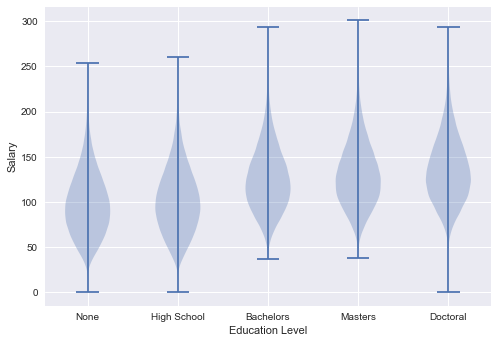

In [30]:
#salary by degree comparison
degree_none = all_data_train[all_data_train['degree'] == 'NONE']['salary']
degree_hs = all_data_train[all_data_train['degree'] == 'HIGH_SCHOOL']['salary']
degree_bach = all_data_train[all_data_train['degree'] == 'BACHELORS']['salary']
degree_master = all_data_train[all_data_train['degree'] == 'MASTERS']['salary']
degree_phd = all_data_train[all_data_train['degree'] == 'DOCTORAL']['salary']

fig, ax = plt.subplots()
ax.violinplot([degree_none,degree_hs,degree_bach,degree_master,degree_phd])
ax.set_xlabel('Education Level')
ax.set_ylabel('Salary')
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['None','High School','Bachelors','Masters','Doctoral'])
plt.show()

In [31]:
# widest range in salary occurs with the Master's degree
# the biggest shift in salary comes from the Bachelor's degree
# distributions of none and hs seem to about the same
# distributions of Masters and Doctoral seem to be about the same

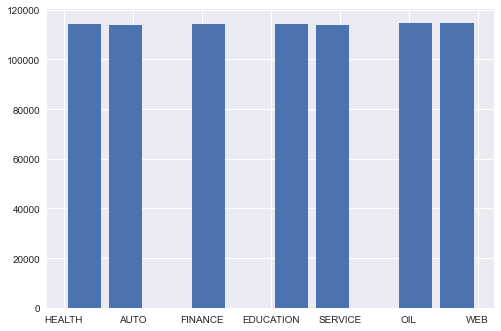

In [32]:
#industry
fig, ax = plt.subplots()
ax.hist(all_data_train['industry'], rwidth = 0.8)
plt.show()

In [33]:
#evenly distributed across industries

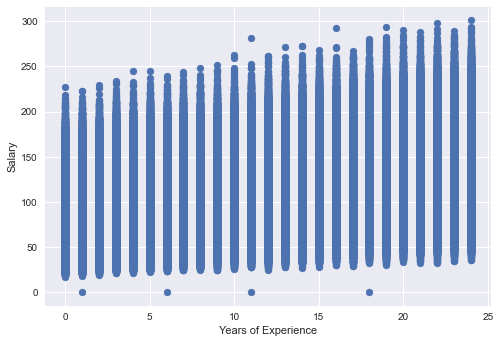

In [34]:
#yearsExperience
fig, ax = plt.subplots()
ax.scatter(all_data_train['yearsExperience'],all_data_train['salary'])
ax.set_xlabel('Years of Experience')
ax.set_ylabel('Salary')
plt.show()

In [35]:
# there seems to be some 0 salaries
all_data_train[all_data_train['salary']==0]
#should these 4 data points be removed?
#does pandas change empty or null values to 0 when reading file?

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0


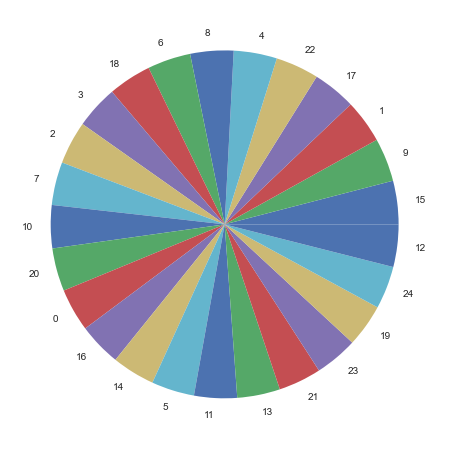

In [36]:
#yearsExperience
fig, ax = plt.subplots(figsize = (8,8))
plt.pie(all_data_train['yearsExperience'].value_counts(), labels = all_data_train['yearsExperience'].value_counts().index)
plt.show()

In [37]:
all_data_train[['yearsExperience','salary']].corr()
#linear correlation between years of experience and salary is pretty low

,yearsExperience,salary
yearsExperience,1.000000,0.375521
salary,0.375521,1.000000


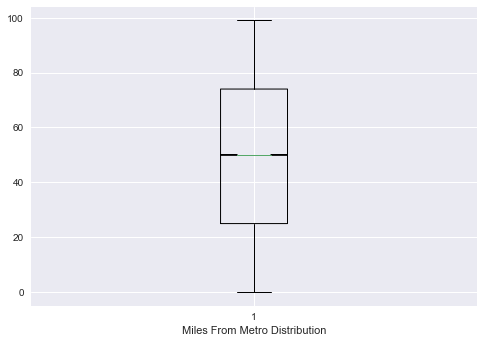

In [38]:
#miles from Metro
fig, ax = plt.subplots()
ax.boxplot(all_data_train['milesFromMetropolis'], notch=True)
ax.set_xlabel('Miles From Metro Distribution')
plt.show()

In [39]:
# seems like 50 is the median miles from metropolis, with 50% of the data being between ~ 25 and 75 miles
# outliers at 0 and 100 miles

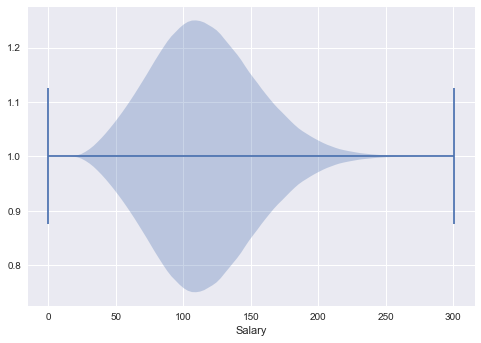

In [40]:
#salary
fig, ax = plt.subplots()
ax.violinplot(all_data_train['salary'],vert = False)
ax.set_xlabel('Salary')
plt.show()

**Data Summary** <br />
companyId - 63 unique, range  for each is 12750-13250 <br />
jobType - 8 unique, each is about 12.5% of total <br />
degree - high school and none are at about 190K, bachelor's, master's, doctoral at about 140K <br />
major - about half have no major listed, the other half are evenly split at around 47K <br />
industry - evenly distributed across all industries, around 119K <br />
yearsExperience - ranges from 0 to 24, data is pretty evenly split among the years <br />
milesfromMetropolis - median is 50, range is 0 to 100, 50% of data is between 25 and 75 miels <br />
salary - normal looking distribution, but right tail is slightly longer than left, mode is between 100 and 125

# One hot encoding categorial variables

In [41]:
# companyId, jobType, degree, major, industry

In [42]:
all_data_train_enc = pd.get_dummies(all_data_train, prefix = ['co','job','deg','mjr','ind'], columns = ['companyId','jobType','degree','major','industry'], drop_first = True)

In [43]:
all_data_train_enc

,jobId,yearsExperience,milesFromMetropolis,salary,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
0,JOB1362684407687,10,83,130,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,JOB1362684407689,10,38,137,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,8,17,142,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,8,16,163,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
6,JOB1362684407693,23,24,178,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,19,94,88,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
999996,JOB1362685407683,12,35,160,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
999997,JOB1362685407684,16,81,64,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
999998,JOB1362685407685,6,5,149,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Fit the Linear Model

In [45]:
lm = LinearRegression()

In [46]:
y = all_data_train_enc[['salary']]
x = all_data_train_enc.iloc[:,1:] # remove jobId column
x = x.drop(labels = 'salary',axis = 1)

In [47]:
x.head()  

,yearsExperience,milesFromMetropolis,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,co_COMP15,co_COMP16,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
0,10,83,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,10,38,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,8,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
6,23,24,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [48]:
lm.fit(x,y)

LinearRegression()

# Update Test Set to Match Training Set

In [49]:
all_data_test.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
288643,JOB1362684696330,COMP61,JANITOR,HIGH_SCHOOL,NONE,HEALTH,21,92,52
462227,JOB1362684869914,COMP26,MANAGER,NONE,NONE,FINANCE,4,60,81
193460,JOB1362684601147,COMP57,MANAGER,NONE,NONE,OIL,18,49,108
945393,JOB1362685353080,COMP34,CEO,NONE,NONE,HEALTH,23,94,141
73964,JOB1362684481651,COMP27,CFO,BACHELORS,NONE,OIL,17,27,173


In [50]:
all_data_test_enc = pd.get_dummies(all_data_test, prefix = ['co','job','deg','mjr','ind'], columns = ['companyId','jobType','degree','major','industry'], drop_first = True)

In [51]:
all_data_test_enc.head()

,jobId,yearsExperience,milesFromMetropolis,salary,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
288643,JOB1362684696330,21,92,52,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
462227,JOB1362684869914,4,60,81,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
193460,JOB1362684601147,18,49,108,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
945393,JOB1362685353080,23,94,141,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
73964,JOB1362684481651,17,27,173,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [52]:
y_test = all_data_test_enc[['salary']]

In [53]:
print(len(y_test))
y_test.head()

200000


,salary
288643,52
462227,81
193460,108
945393,141
73964,173


In [54]:
x_test = all_data_test_enc.iloc[:,1:] # remove jobID column
x_test = x_test.drop(labels = 'salary', axis = 1) #remove salary column
x_test.head()

,yearsExperience,milesFromMetropolis,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,co_COMP15,co_COMP16,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
288643,21,92,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
462227,4,60,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
193460,18,49,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
945393,23,94,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
73964,17,27,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


# Prediction & Model Assessment

In [55]:
predictions = lm.predict(x_test)

In [56]:
predictions

array([[ 73.63451082],
       [ 95.90816535],
       [128.41651884],
       ...,
       [166.41402623],
       [140.3536202 ],
       [159.94168002]])

In [57]:
len(predictions)

200000

In [58]:
#type(predictions) #np ndarray
#type(y_test) #pd df
pd.concat([y_test,pd.DataFrame(predictions)], axis = 1, ignore_index = True, names = ['Salary','Prediction'])

,0,1
0,NaN,73.634511
1,101.0,95.908165
2,NaN,128.416519
3,NaN,135.689301
4,NaN,164.745862
...,...,...
999972,56.0,NaN
999975,97.0,NaN
999979,181.0,NaN
999981,132.0,NaN


In [59]:
residuals = np.array(y_test) - predictions
residuals

array([[-21.63451082],
       [-14.90816535],
       [-20.41651884],
       ...,
       [  6.58597377],
       [  2.6463798 ],
       [-39.94168002]])

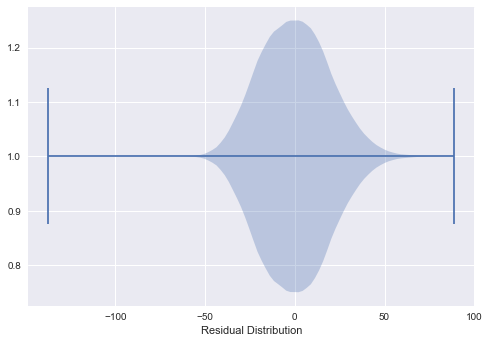

In [60]:
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals, vert = False)
ax.set_xlabel('Residual Distribution')
plt.show()

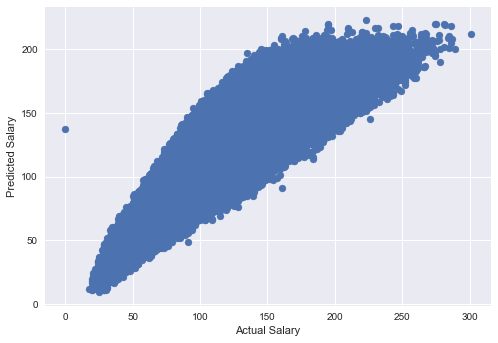

In [61]:
# actual vs predicted
fig, ax = plt.subplots()
ax.scatter(np.array(y_test),predictions)
ax.set_xlabel('Actual Salary')
ax.set_ylabel('Predicted Salary')
plt.show()

In [62]:
lm.intercept_

array([134.81234947])

In [63]:
lm.coef_

array([[ 2.00996961e+00, -3.99766088e-01, -1.16082627e-01,
         9.51189120e-02,  2.11334298e-01,  1.18773551e-01,
         2.45531474e-01, -2.08057440e-04,  1.21218805e-01,
         1.59641896e-01,  1.29471219e-01, -2.88414181e-02,
         1.22076772e-01,  3.02648100e-01, -1.77810276e-01,
         3.70216887e-01,  2.06393721e-01, -6.54833958e-02,
         1.68332193e-01,  2.49912439e-01,  1.29475775e-01,
         5.31798367e-02,  3.90567679e-01,  2.44649215e-01,
         2.15136533e-01, -2.16125406e-01, -1.82737591e-02,
         1.93469087e-02,  2.42477555e-01,  3.76479329e-01,
        -2.01213981e-02,  1.60045214e-01, -7.43738219e-02,
        -6.64245333e-02, -4.26640182e-02,  3.12168894e-01,
         2.31877299e-01,  3.02763455e-01,  5.58499702e-02,
         1.75559064e-01,  5.01001687e-01,  1.69344863e-01,
         5.84278849e-02, -2.73090316e-01, -1.78950129e-01,
         2.51544163e-01,  4.30781354e-02, -1.57968591e-01,
        -8.25525132e-02,  1.40875592e-01, -2.85702717e-0

In [67]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions))
print('MSE: ',metrics.mean_squared_error(y_test, predictions))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions)))

MAE:  15.861349709265646
MSE:  384.8791704495597
RMSE:  3.9826310034028567


# Model 2 - Without company ID

In [68]:
x2 = x.filter(regex = '^[^co_.*]')
lm2 = LinearRegression()
lm2.fit(x2,y)

LinearRegression()

In [69]:
x_test2 = x_test.filter(regex = '^[^co.*]')
predictions2 = lm2.predict(x_test2)

In [70]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions2))
print('MSE: ',metrics.mean_squared_error(y_test, predictions2))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions2)))

MAE:  15.860697183909389
MSE:  384.839110636607
RMSE:  3.982549081167662


In [71]:
#not much improvement, but this means we can drop the companyId data

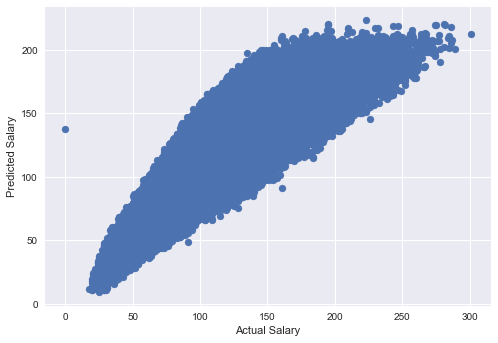

In [72]:
# actual vs predicted
fig, ax = plt.subplots()
ax.scatter(np.array(y_test),predictions2)
ax.set_xlabel('Actual Salary')
ax.set_ylabel('Predicted Salary')
plt.show()

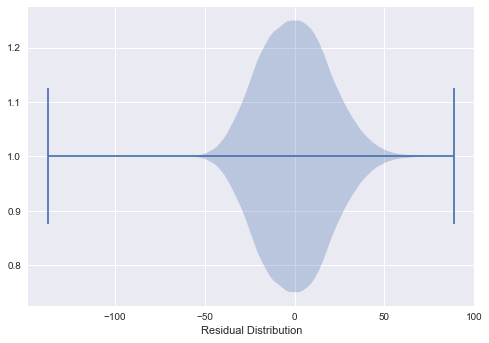

In [73]:
residuals2 = np.array(y_test) - predictions2
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals2, vert = False)
ax.set_xlabel('Residual Distribution')
plt.show()

# Model 3 - Gradient Boost

In [76]:
gbm = GradientBoostingRegressor(criterion = 'mse')
# use default learning rate of 0.1 and 100 estimators, least squares loss function
# but use mse, and read up on friedman mse

In [92]:
gbm.fit(x,np.array(y).ravel())

GradientBoostingRegressor(criterion='mse')

In [93]:
predictions3 = gbm.predict(x_test)

In [94]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions3))
print('MSE: ',metrics.mean_squared_error(y_test, predictions3))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions3)))

MAE:  15.956055397256948
MSE:  394.24891168139646
RMSE:  3.9945031477340143


In [ ]:
# this model has larger MAE and MSE than the other two

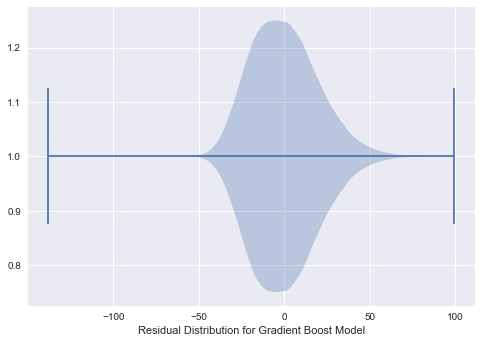

In [115]:
residuals3 = np.array(y_test).ravel() - predictions3
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals3, vert = False)
ax.set_xlabel('Residual Distribution for Gradient Boost Model')
plt.show()

# Model 4 - Gradient Boost with default criterion setting (Friedman's MSE)

In [138]:
gbm2 = GradientBoostingRegressor()
# use default learning rate of 0.1 and 100 estimators, least squares loss function

In [139]:
gbm2.fit(x,np.array(y).ravel())

GradientBoostingRegressor()

In [140]:
predictions4 = gbm2.predict(x_test)

In [141]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions4))
print('MSE: ',metrics.mean_squared_error(y_test, predictions4))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions4)))

MAE:  15.956055397256948
MSE:  394.24891168139607
RMSE:  3.9945031477340143


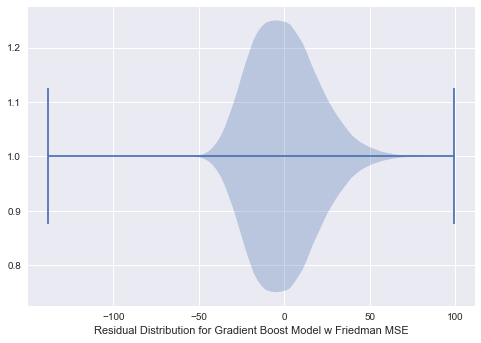

In [142]:
residuals4 = np.array(y_test).ravel() - predictions4
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals4, vert = False)
ax.set_xlabel('Residual Distribution for Gradient Boost Model w Friedman MSE')
plt.show()

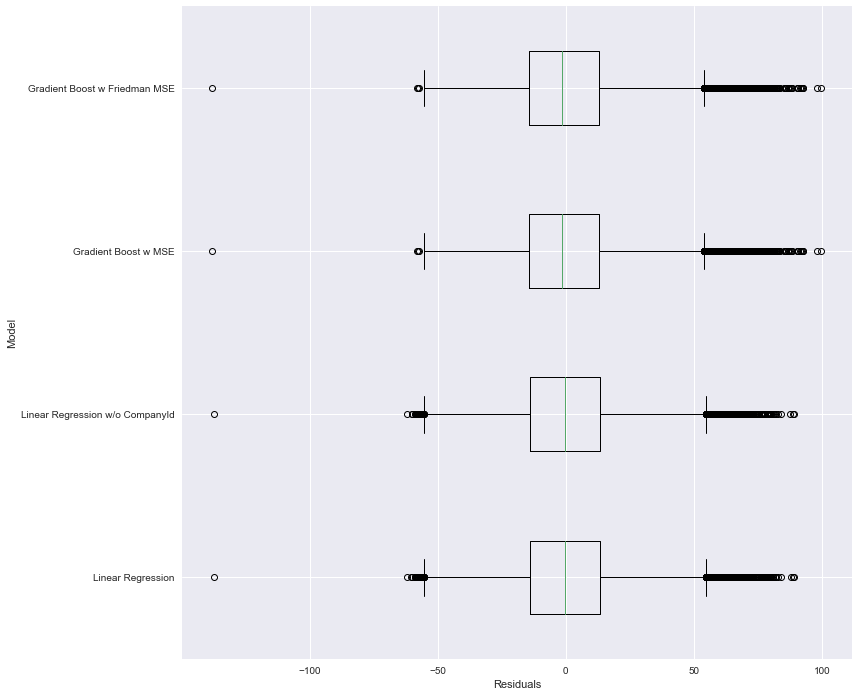

In [149]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.boxplot([residuals.ravel(),residuals2.ravel(),residuals3.ravel(),residuals4.ravel()], vert = False)
ax.set_ylabel('Model')
ax.set_xlabel('Residuals')
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(['Linear Regression','Linear Regression w/o CompanyId','Gradient Boost w MSE','Gradient Boost w Friedman MSE'])
plt.show()